# Training

In [ ]:
!pip install tensorboardX
!pip install uncertainty-metrics

In [ ]:
!git clone https://github.com/pollinab/repulsive_ensembles.git

In [ ]:
%cd repulsive_ensembles

In [4]:
!gzip -d data/notMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
!gzip -d data/notMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz

In [5]:
#!python setup.py install

In [6]:
#!python experiments/exp_mnist.py

In [7]:
from utils.mnist_config import configuration
from training.train_classifier import train
from models.MLP import Net
from models.ensemble import Ensemble
from torchvision.datasets import MNIST
import numpy as np
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm.notebook import tqdm
from torchvision import transforms
import os
import torch

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
test_set = MNIST(os.getcwd(), train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

test_x, test_labels = next(iter(test_loader))

ood_set = MNIST('data/notMNIST', train=False, transform=transform, download=False)
ood_loader = torch.utils.data.DataLoader(ood_set, batch_size=len(ood_set), shuffle=False)

ood_data, ood_labels = next(iter(ood_loader))

In [10]:
n_particles = 15
layer_sizes = [28*28, 100, 100, 100, 10]

mnet = Net(layer_sizes, classification=True, act=F.relu, out_act =F.softmax, bias=True).to(device)

l = []
for _ in range(n_particles):
  l.append(torch.cat([p.flatten() for p in Net(layer_sizes, classification =True, act=F.relu,out_act =F.softmax, bias=True, no_weights=False).parameters()][len(mnet.param_shapes):]).detach())

initial_particles = torch.stack(l).to(device)

ensemble = Ensemble(device = device, net=mnet,particles=initial_particles)

In [11]:
config = configuration(args=['--n_epochs', '15', '--method', 'kde', '--kernel', 'laplace', '--adversarial', 'True', '--functional', 'False'])

In [12]:
train_history = train(ensemble, train_loader, config)

-------------------Start training------------------
Train epoch: 0  train loss: 25928.62704493857 driving: 0.06185970827937126 repulsive: 7.348449435085058e-05
Train epoch: 1  train loss: 12968.690417167469 driving: 0.035357069224119186 repulsive: 5.7481589465169236e-05
Train epoch: 2  train loss: 10549.895676832934 driving: 0.04036485031247139 repulsive: 3.71238638763316e-05
Train epoch: 3  train loss: 8963.72198277661 driving: 0.035174641758203506 repulsive: 2.2112184524303302e-05
Train epoch: 4  train loss: 7688.157123272235 driving: 0.03276095539331436 repulsive: 1.0481488061486743e-05
Train epoch: 5  train loss: 6678.821382441072 driving: 0.029853545129299164 repulsive: 9.564276297169272e-06
Train epoch: 6  train loss: 5862.759466970068 driving: 0.01639782264828682 repulsive: 9.307049367635045e-06
Train epoch: 7  train loss: 5185.64472387591 driving: 0.0260308850556612 repulsive: 5.5209688980539795e-06
Train epoch: 8  train loss: 4630.128333132491 driving: 0.01852627471089363 repu

# Visualization

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#importlib.reload(visualization)

In [22]:
from utils.visualization import plot_ordered_data, plot_calibration

predicted classes for 1 row
tensor([3, 3, 3, 3, 3, 3, 3, 0, 3, 3])


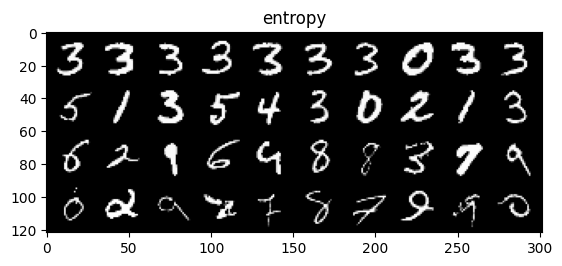

predicted classes for 1 row
tensor([3, 5, 3, 3, 0, 5, 3, 6, 3, 3])


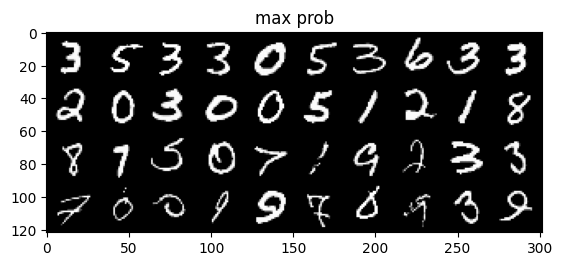

predicted classes for 1 row
tensor([3, 3, 3, 3, 3, 0, 3, 3, 3, 3])


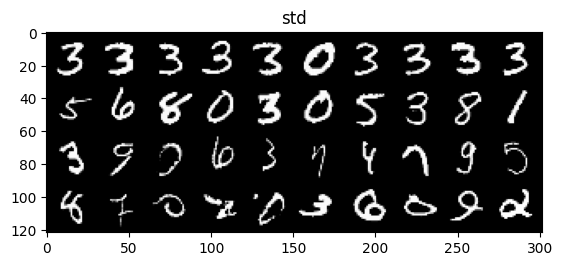

In [23]:
plot_ordered_data(ensemble, test_x)

predicted classes for 1 row
tensor([3, 3, 0, 1, 1, 3, 3, 3, 2, 3])


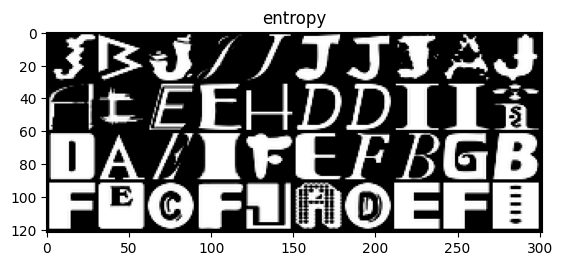

predicted classes for 1 row
tensor([3, 3, 0, 1, 1, 3, 3, 3, 3, 2])


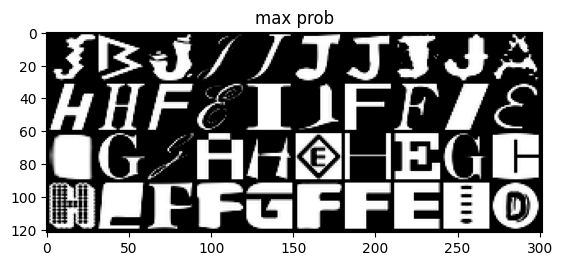

predicted classes for 1 row
tensor([3, 0, 3, 1, 1, 3, 3, 3, 3, 2])


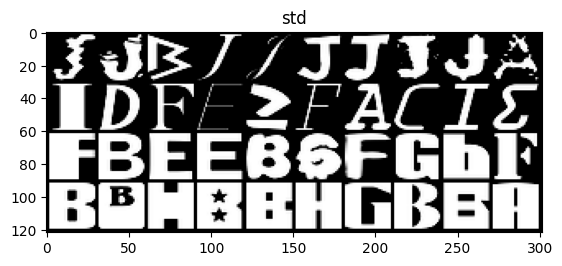

In [24]:
plot_ordered_data(ensemble, data=ood_data)

In [25]:
rot_transform = transforms.Compose([transforms.RandomRotation([-90, 90]), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [26]:
rotated = MNIST(os.getcwd(), train=False, transform=rot_transform, download=False)

rotated_loader = torch.utils.data.DataLoader(rotated, batch_size=len(rotated), shuffle=False)

rotated_data, rotated_labels = next(iter(rotated_loader))

predicted classes for 1 row
tensor([3, 0, 3, 3, 6, 0, 6, 5, 5, 0])


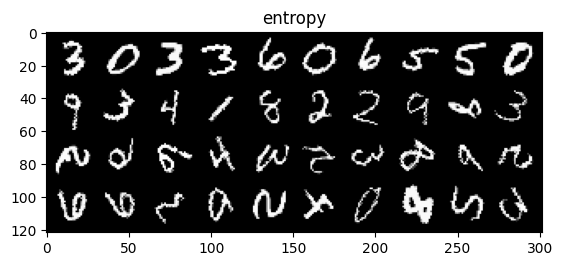

predicted classes for 1 row
tensor([3, 3, 0, 0, 6, 3, 5, 6, 0, 5])


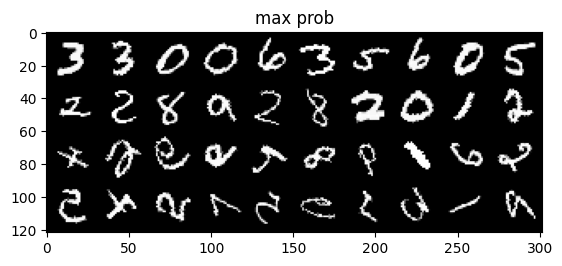

predicted classes for 1 row
tensor([3, 0, 3, 6, 3, 0, 5, 6, 0, 3])


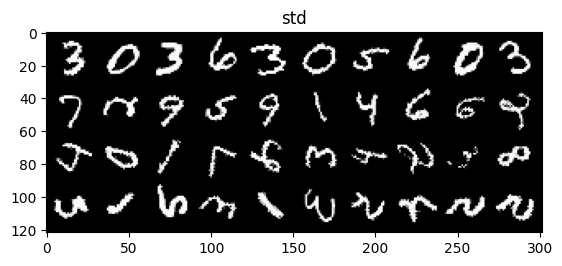

In [27]:
plot_ordered_data(ensemble, data=rotated_data)

# Calibration

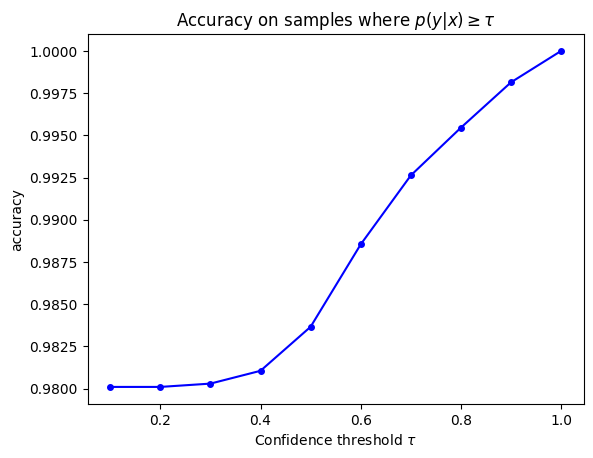

In [28]:
plot_calibration(ensemble, test_x, test_labels)

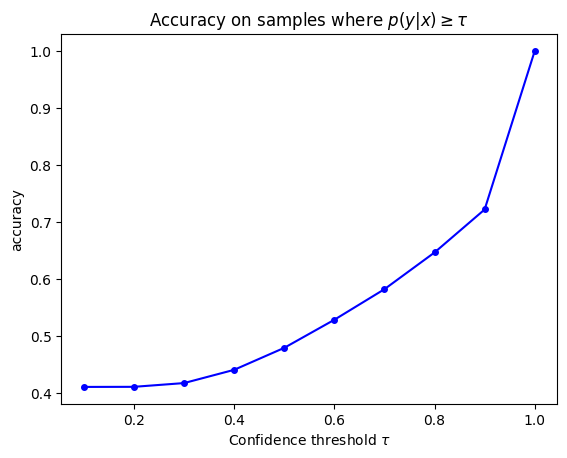

In [29]:
plot_calibration(ensemble, rotated_data, rotated_labels)